# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [30]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import load_workbook

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [31]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [32]:
azdias_cols = azdias.columns.tolist()
customers_cols = customers.columns.tolist()

Check columns in Azdias and Customers databases

In [33]:
# We want to make sure that the columns in both the datasets are the same (besides the customer specific cols
# 'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE' columns).
cols1 = customers_cols
for i in ['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE']:
    cols1.remove(i)

cols2 = azdias_cols
cols1.sort() 
cols2.sort() 

if cols1 == cols2: 
    print ("The lists 1 and 2 are the same") 
else: 
    print ("not equal") 


The lists 1 and 2 are the same


Upon looking into the amount of data we have for both - the population of Germany and customer base of the mail order sales company, it appears that nearly 21% of Germany's population is a customer of the company

In [34]:
azdias.shape

(891221, 366)

In [35]:
customers.shape

(191652, 369)

In [36]:
customers.shape[0]/azdias.shape[0]

0.21504430438690292

The raw dataset that we are presented with has 366 features, majority of these fatures have been dropped as that level of granualarity may not be completely relevant to our task.
Refer to the "Relevant" tab and "Removed Feats" tab of the "DIAS Attributes_relevant.xlsx" file to find out the features we have retained and removed respoectively.

The following cell take the items from the excel file we created and detects columns with unknown values in the form of (0,-1 & 9) and changes these to NaN to simplify pre-processing.

In [37]:
wb = load_workbook("DIAS Attributes_relevant.xlsx")  # Work Book
ws = wb.get_sheet_by_name('Relevant')  # Work Sheet
column1 = ws['A']  # Column
column2 = ws['B']  # Column

relevant_cols = [column1[x].value for x in range(len(column1))]
relevant_cols_mean = [column2[x].value for x in range(len(column2))]


<ipython-input-37-2641bba79a56>:2: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  ws = wb.get_sheet_by_name('Relevant')  # Work Sheet


In [38]:
Unk_1 = wb.get_sheet_by_name('-1_Unk')  # Work Sheet
Unk_1_col = Unk_1['A']  # Column

Unk_0 = wb.get_sheet_by_name('0_Unk')  # Work Sheet
Unk_0_col = Unk_0['A']  # Column

Unk_9 = wb.get_sheet_by_name('9_Unk')  # Work Sheet
Unk_9_col = Unk_9['A']  # Column

Unk_1_list = [Unk_1_col[x].value for x in range(len(Unk_1_col))]

Unk_0_list = [Unk_0_col[x].value for x in range(len(Unk_0_col))]

Unk_9_list = [Unk_9_col[x].value for x in range(len(Unk_9_col))]



<ipython-input-38-aea156147448>:1: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  Unk_1 = wb.get_sheet_by_name('-1_Unk')  # Work Sheet
<ipython-input-38-aea156147448>:4: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  Unk_0 = wb.get_sheet_by_name('0_Unk')  # Work Sheet
<ipython-input-38-aea156147448>:7: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  Unk_9 = wb.get_sheet_by_name('9_Unk')  # Work Sheet


Apply this to the Population dataset

In [39]:
azdias_clean = azdias[azdias.columns.intersection(relevant_cols)]


azdias_clean[Unk_1_list] = azdias_clean[Unk_1_list].replace(-1, np.nan)
azdias_clean[Unk_0_list] = azdias_clean[Unk_0_list].replace(0, np.nan)
azdias_clean[Unk_9_list] = azdias_clean[Unk_9_list].replace(9, np.nan)

azdias_clean


c:\Users\avadi\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,LNR,AGER_TYP,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BEKLEIDUNG_GEH,...,SEMIO_RAT,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,2.0,0,10,NaN,0,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2
1,910220,NaN,8A,8.0,51.0,5.0,0,10,NaN,0,...,6,3.0,1.0,NaN,2.0,3.0,9.0,4.0,5,1
2,910225,NaN,4C,4.0,24.0,3.0,0,10,0.0,0,...,4,2.0,0.0,NaN,1.0,3.0,9.0,2.0,5,3
3,910226,2.0,2A,2.0,12.0,2.0,0,10,0.0,0,...,3,1.0,0.0,NaN,1.0,NaN,9.0,7.0,3,4
4,910241,NaN,6B,6.0,43.0,5.0,3,5,10.0,6,...,2,2.0,0.0,NaN,2.0,2.0,9.0,3.0,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,825761,NaN,7A,7.0,41.0,5.0,0,10,0.0,0,...,4,3.0,0.0,NaN,1.0,3.0,4.0,3.0,4,3
891217,825771,NaN,9D,9.0,51.0,4.0,0,10,0.0,0,...,4,NaN,0.0,NaN,NaN,6.0,9.0,5.0,6,2
891218,825772,NaN,4C,4.0,24.0,4.0,0,9,0.0,5,...,7,2.0,0.0,NaN,1.0,NaN,5.0,7.0,4,2
891219,825776,NaN,9D,9.0,51.0,3.0,0,10,0.0,0,...,5,0.0,0.0,NaN,2.0,1.0,9.0,5.0,5,1


In [40]:
# If over 28% of the column has unkown vlaues, the  column in being dropped
azdias_clean = azdias_clean.loc[:, azdias_clean.isnull().mean() < .28]

Apply this to the customer dataset

In [41]:
cust_clean = customers[customers.columns.intersection(relevant_cols)]

cust_clean[Unk_1_list] = cust_clean[Unk_1_list].replace(-1, np.nan)
cust_clean[Unk_0_list] = cust_clean[Unk_0_list].replace(0, np.nan)
cust_clean[Unk_9_list] = cust_clean[Unk_9_list].replace(9, np.nan)

cust_clean

c:\Users\avadi\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,LNR,AGER_TYP,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BEKLEIDUNG_GEH,...,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ALTERSKATEGORIE_GROB
0,9626,2.0,1A,1.0,13.0,5.0,0,10,0.0,0,...,NaN,1.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,4
1,9628,NaN,NaN,NaN,NaN,NaN,0,6,0.0,0,...,NaN,1.0,NaN,9.0,NaN,3,FOOD,SINGLE_BUYER,0,4
2,143872,NaN,5D,5.0,34.0,2.0,0,10,0.0,0,...,NaN,2.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,4
3,143873,1.0,4C,4.0,24.0,2.0,0,10,0.0,0,...,NaN,1.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,4
4,143874,NaN,7B,7.0,41.0,6.0,1,3,0.0,0,...,NaN,2.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,154561,1.0,1C,1,14,4.0,0,7,0.0,0,...,NaN,2.0,6.0,9.0,1.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,3
191648,154563,NaN,5B,5,32,2.0,0,10,0.0,0,...,NaN,2.0,NaN,9.0,3.0,3,COSMETIC,SINGLE_BUYER,0,4
191649,148813,2.0,4D,4,24,2.0,0,10,0.0,6,...,NaN,1.0,3.0,9.0,3.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,4
191650,148852,3.0,4C,4,24,4.0,1,5,0.0,5,...,NaN,1.0,4.0,9.0,2.0,3,FOOD,SINGLE_BUYER,0,3


In [42]:
cust_clean.isnull().sum()

# If over 28% of the column has unkown vlaues, the  column in being dropped
cust_clean = cust_clean.loc[:, cust_clean.isnull().mean() < .28]

Including the common features and dropping all NaN values in our dataset

In [43]:
# FInd the columns that are common in between the cleaned customer and cleaned population table so there is consistency in the features
common_cols = azdias_clean.columns.intersection(cust_clean.columns).to_list()


In [44]:
# Dropping all NaN rows
azdias_clean = azdias_clean[common_cols].dropna()
azdias_clean

,LNR,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_DATUM,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,...,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SHOPPER_TYP,SOHO_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ALTERSKATEGORIE_GROB
1,910220,8A,8.0,51.0,5.0,0,10,0,0,0,...,3,7,6,3.0,1.0,2.0,9.0,4.0,5,1
2,910225,4C,4.0,24.0,3.0,0,10,0,0,6,...,3,3,4,2.0,0.0,1.0,9.0,2.0,5,3
3,910226,2A,2.0,12.0,2.0,0,10,0,0,0,...,1,4,3,1.0,0.0,1.0,9.0,7.0,3,4
4,910241,6B,6.0,43.0,5.0,3,5,6,1,6,...,2,4,2,2.0,0.0,2.0,9.0,3.0,4,3
5,910244,8C,8.0,54.0,2.0,0,10,0,0,0,...,4,7,7,0.0,0.0,2.0,9.0,7.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891214,825745,3A,3.0,23.0,4.0,0,10,0,0,0,...,3,5,6,3.0,0.0,2.0,9.0,3.0,5,1
891215,825758,5A,5.0,31.0,6.0,0,10,0,0,0,...,7,6,7,1.0,0.0,1.0,9.0,3.0,4,2
891218,825772,4C,4.0,24.0,4.0,0,9,5,6,0,...,3,6,7,2.0,0.0,1.0,5.0,7.0,4,2
891219,825776,9D,9.0,51.0,3.0,0,10,0,0,0,...,5,7,5,0.0,0.0,2.0,9.0,5.0,5,1


In [45]:

cust_clean = cust_clean[common_cols[:78] + ['PRODUCT_GROUP','CUSTOMER_GROUP','ONLINE_PURCHASE'] + common_cols[78:]]

cust_clean = cust_clean.dropna()

cust_clean


,LNR,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_DATUM,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,...,SHOPPER_TYP,SOHO_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ALTERSKATEGORIE_GROB
0,9626,1A,1.0,13.0,5.0,0,10,0,0,0,...,3.0,0.0,1.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,4
2,143872,5D,5.0,34.0,2.0,0,10,0,0,6,...,1.0,0.0,2.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,4
3,143873,4C,4.0,24.0,2.0,0,10,0,0,0,...,0.0,0.0,1.0,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,4
4,143874,7B,7.0,41.0,6.0,1,3,0,6,0,...,1.0,0.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,3
5,143888,5D,5.0,34.0,4.0,0,10,0,6,0,...,1.0,0.0,2.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,154561,1C,1,14,4.0,0,7,0,0,0,...,1.0,0.0,2.0,9.0,1.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,3
191648,154563,5B,5,32,2.0,0,10,0,0,0,...,3.0,0.0,2.0,9.0,3.0,3,COSMETIC,SINGLE_BUYER,0,4
191649,148813,4D,4,24,2.0,0,10,6,0,0,...,0.0,0.0,1.0,9.0,3.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,4
191650,148852,4C,4,24,4.0,1,5,5,0,0,...,2.0,0.0,1.0,9.0,2.0,3,FOOD,SINGLE_BUYER,0,3


In [46]:
azdias_clean = azdias_clean[azdias_clean.CAMEO_INTL_2015!='XX']
cust_clean = cust_clean[cust_clean.CAMEO_INTL_2015!='XX']

We are using over 70% of the data observations for the purpose of our analysis

In [47]:
azdias_clean.shape[0]/azdias.shape[0]

0.8266254946865031

In [48]:
cust_clean.shape[0]/customers.shape[0]

0.7000657441612923

In [49]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [50]:
cust_clean.dtypes

LNR                       int64
CAMEO_DEU_2015           object
CAMEO_DEUG_2015          object
CAMEO_INTL_2015          object
CJT_GESAMTTYP           float64
                         ...   
ZABEOTYP                  int64
PRODUCT_GROUP            object
CUSTOMER_GROUP           object
ONLINE_PURCHASE           int64
ALTERSKATEGORIE_GROB      int64
Length: 82, dtype: object

In [51]:
cust_clean.dtypes 

for col in cust_clean:
    if cust_clean[col].dtypes != "int64" and cust_clean[col].dtypes != "float":
        print(col)
        

CAMEO_DEU_2015
CAMEO_DEUG_2015
CAMEO_INTL_2015
OST_WEST_KZ
PRODUCT_GROUP
CUSTOMER_GROUP


In [53]:
# Function that converts categorical data to numeric and make sure everything in consitent
def convert_to_num1(df):
    df['CAMEO_DEUG_2015'] = pd.to_numeric(df['CAMEO_DEUG_2015'])    
    df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'])

In [54]:
 convert_to_num1(azdias_clean)

<ipython-input-53-6ac07478349c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CAMEO_DEUG_2015'] = pd.to_numeric(df['CAMEO_DEUG_2015'])
<ipython-input-53-6ac07478349c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'])


In [79]:
 convert_to_num1(cust_clean)

<ipython-input-53-6ac07478349c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CAMEO_DEUG_2015'] = pd.to_numeric(df['CAMEO_DEUG_2015'])
<ipython-input-53-6ac07478349c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'])


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

<AxesSubplot:ylabel='PRODUCT_GROUP'>

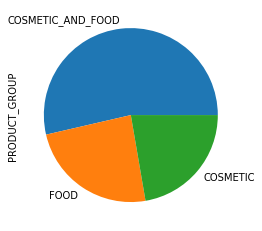

In [81]:
cust_clean.PRODUCT_GROUP.value_counts(normalize=True).plot.pie()

In [75]:
def createhist(col, df1=azdias_clean, df2=cust_clean):

    x = df1[col].unique().tolist()
    x.sort()
    x

    f, ax = plt.subplots(figsize=(15,8))
    df1[col].value_counts(normalize=True).loc[x].plot.bar(width = 1)
    ax.set_title("Azdias - "+col)

    f, ax = plt.subplots(figsize=(15,8))
    df2[col].value_counts(normalize=True).loc[x].plot.bar(width = 1)
    ax.set_title("Customers - "+col)



CAMEO_DEUG_2015 - CAMEO classification 2015 - Uppergroup
- 1:upper class
- 2:upper middleclass
- 3:established middleclasse
- 4:consumption-oriented middleclass 
- 5:active middleclass 
- 6:low-consumption middleclass
- 7:lower middleclass
- 8:working class
- 9:urban working class


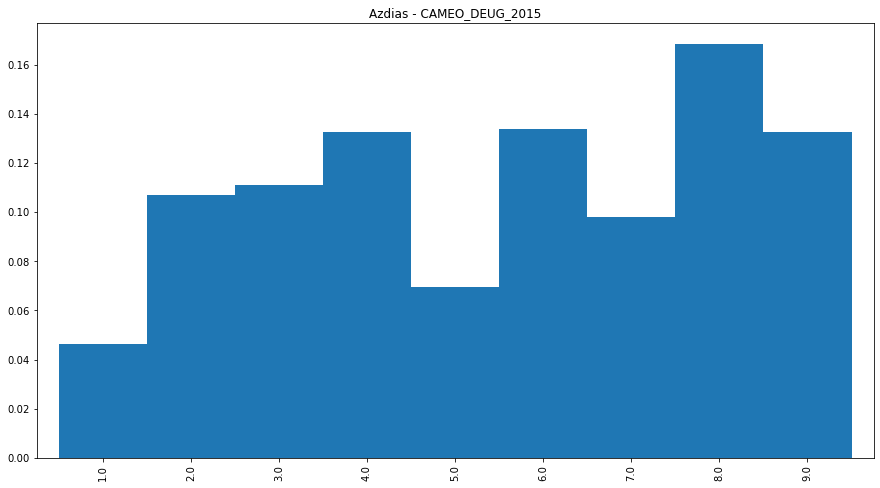

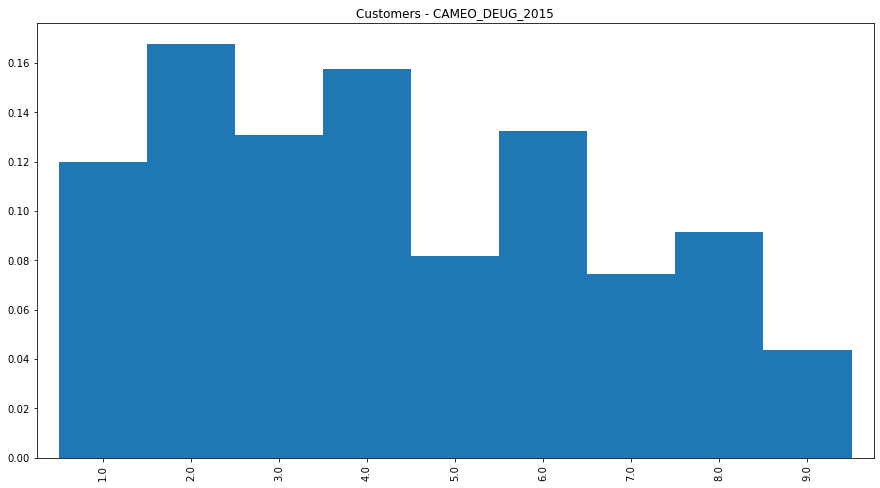

In [76]:
createhist('CAMEO_DEUG_2015')

### Unsupervised learning

In [85]:
# Frequency Encoding for the CAMEO_DEU_2015
fe = cust_clean.groupby('CAMEO_DEU_2015').size()/len(cust_clean)
cust_clean.loc[:,'CAMEO_DEU_2015_freq'] = cust_clean['CAMEO_DEU_2015'].map(fe)

c:\Users\avadi\anaconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
c:\Users\avadi\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [111]:
#cust_clean[cust_clean.OST_WEST_KZ=='O']

cust_clean['OST_WEST_KZ_encod'] = cust_clean.OST_WEST_KZ.astype("category").cat.codes


<ipython-input-111-2047b124f5f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cust_clean['OST_WEST_KZ_encod'] = cust_clean.OST_WEST_KZ.astype("category").cat.codes


In [86]:
cust_clean

,LNR,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,D19_BANKEN_ANZ_12,D19_BANKEN_DATUM,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,...,SOHO_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ALTERSKATEGORIE_GROB,CAMEO_DEU_2015_freq
0,9626,1A,1.0,13.0,5.0,0,10,0,0,0,...,0.0,1.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,4,0.029858
2,143872,5D,5.0,34.0,2.0,0,10,0,0,6,...,0.0,2.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,4,0.031609
3,143873,4C,4.0,24.0,2.0,0,10,0,0,0,...,0.0,1.0,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,4,0.064598
4,143874,7B,7.0,41.0,6.0,1,3,0,6,0,...,0.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,3,0.024029
5,143888,5D,5.0,34.0,4.0,0,10,0,6,0,...,0.0,2.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,3,0.031609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,154561,1C,1.0,14.0,4.0,0,7,0,0,0,...,0.0,2.0,9.0,1.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,3,0.015704
191648,154563,5B,5.0,32.0,2.0,0,10,0,0,0,...,0.0,2.0,9.0,3.0,3,COSMETIC,SINGLE_BUYER,0,4,0.012015
191649,148813,4D,4.0,24.0,2.0,0,10,6,0,0,...,0.0,1.0,9.0,3.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,4,0.015145
191650,148852,4C,4.0,24.0,4.0,1,5,5,0,0,...,0.0,1.0,9.0,2.0,3,FOOD,SINGLE_BUYER,0,3,0.064598


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [25]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

c:\Users\avadi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [24]:
mailout_train

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42957,66338,2,1.0,0.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,1.0,1.0,4.0,8.0,7.0,1,0,1,4
42958,67629,-1,1.0,0.0,NaN,NaN,NaN,NaN,14.0,1.0,...,1.0,1.0,1.0,5.0,9.0,7.0,1,0,1,3
42959,68273,1,1.0,16.0,NaN,NaN,NaN,NaN,10.0,2.0,...,1.0,2.0,1.0,2.0,9.0,7.0,1,0,1,4
42960,68581,2,1.0,18.0,NaN,NaN,NaN,NaN,13.0,3.0,...,2.0,3.0,4.0,2.0,9.0,2.0,3,0,2,4
